In [94]:
import os
import pandas as pd
from collections import Counter, defaultdict
from venny4py import venny4py
import matplotlib.pyplot as plt
import random

from copy import copy
import numpy as np
from pyteomics import auxiliary as aux
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import rankdata, ttest_ind, ttest_rel, wilcoxon, scoreatpercentile
from scipy.optimize import curve_fit
import scipy

In [ ]:
# Install all missing Python libraries!

In [ ]:
# Install modified scikit-learn package presented in the manuscript
!pip install https://github.com/markmipt/scikit-learn/archive/refs/heads/min_groups_leaf.zip --upgrade

In [51]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import roc_auc_score

In [3]:
# Enter here path to project directory
infolder = "/home/mark/final_test_AD/"

In [ ]:
# Create project directory if it is not exist
if not os.path.isdir(infolder):
    os.makedirs(infolder)

In [ ]:
# Move to the project directory
%cd $infolder
%pwd

In [ ]:
# DIA data set is available at ProteomeXchange under PXD025668 identifier.
    
# DDA data is available for general research use according to the following requirements for
# data access and data attribution (https://adknowledgeportal.synapse.org/Data%20Access). 
# The following data sets were included into this study: ACT (syn5759376), Banner (syn7170616), 
# MSSB (syn3159438) and BLSA (syn3606086).

In [ ]:
# Download the raw data described above and put into project directory.
# All required filenames are provided in the sample file placed in the Github (AD_Sample.tsv).

In [ ]:
# For the next step, you should install ThermoRawFileParser (https://github.com/compomics/ThermoRawFileParser)

In [ ]:
# Run ThermoRawFileParser for all raw files with an option to extract only MS1 spectra

for fn in os.listdir(infolder):
    if fn.endswith('.raw'):
        infile1 = os.path.join(infolder, fn)
        !ThermoRawFileParser -i $infile1 -L 1 -o $infolder

In [ ]:
# For the next step, you should install biosaur2 (https://github.com/markmipt/biosaur2)
!pip install biosaur2

In [4]:
df1 = pd.read_table('/home/mark/ms1_china_AD_2024/ACT_Proteomics_PFC_RAW_ad_act03.features.tsv')

In [ ]:
# Run biosaur2 for all mzML files to extract peptide isotope clusters.

for fn in os.listdir(infolder):
    if fn.endswith('.mzML'):
        mzmlname = os.path.join(infolder, fn)
        !biosaur2 $mzmlname -minlh 5

In [ ]:
# For the next step, you should install ms1searchpy (https://github.com/markmipt/ms1searchpy)
!pip install ms1searchpy

In [ ]:
# For the next step, you should install DeepLC (https://github.com/compomics/DeepLC)
# The recommended version is the clone available at https://github.com/markmipt/DeepLC
!pip install https://github.com/markmipt/DeepLC/archive/refs/heads/alternative_best_model.zip

In [ ]:
# For the next step, you should put protein fasta database into working directory
# The database is placed along this notebook on the github (sprot_human_shuffled.fasta)

In [ ]:
# Run ms1searchpy for all *features.tsv files generated by biosaur2

infasta = os.path.join(infolder, 'sprot_human_shuffled.fasta')
for fn in os.listdir(infolder):
    if fn.endswith('.features.tsv'):
        ftrfile = os.path.join(infolder, fn)
        protfile = ftrfile.replace('.features.tsv', '.features_proteins.tsv')
        if not os.path.exists(protfile):
            !ms1searchpy $ftrfile -d $infasta -sc 1 -i 2 -nproc 8 -mc 0 -cmin 1 -ptol 8 -fdr 5 -ts 2 -ml 1 -deeplc 1 -lmin 7 -mcalib 0 -deeplc_library /tmp/deeplc345.lib

In [ ]:
# For the next step, you should put sample list for MSA and Controls samples into working directory
# The sample list is placed along this notebook on the github (AD_Sample.tsv)

In [12]:
# Auxilary functions to process files

def update_filename(x):
    for ii in ['_04', '_3', '_2', '-2', '']:
        if os.path.isfile(os.path.join(infolder, x+ii+'.features_proteins_full.tsv')):
            return x+ii
    print('missing file: %s' % (x, ))
    return '-'

def count_proteins(x):
    dfprots = pd.read_table(os.path.join(infolder, x+'.features_proteins.tsv'))
    return len(dfprots)

In [35]:
df1 = pd.read_csv(os.path.join(infolder, 'AD_Sample.tsv'), sep='\t')
df1['BatchMS'] = df1['Batch'].fillna(df1['filename'].apply(lambda x: x.split('.')[0]))

df1['Batch'] = df1['BatchMS'].apply(lambda x: x.split('.')[0])
df1['BatchOrig'] = df1['Batch']

df1['filename'] = df1['filename'].apply(lambda x: x.replace('BANNER', 'Banner'))

filemap = {
    'BANNER': 'Banner_Proteomics_PFC_RAW_',
    'ACT': 'ACT_Proteomics_PFC_RAW_',
    'BLSA': 'AMP-AD_BLSA_EMORY_QEPLUS_',
    'MSSB': 'MSSB_Proteomics_PFC_RAW_',
    
    
}
df1['File Name'] = df1.apply(lambda x: filemap[x['BatchOrig']] + x['filename'].split('.')[-1], axis=1)
df1['File Name'] = df1['File Name'].apply(update_filename)

df1 = df1[df1['File Name'] != '-']

df1['# IDs'] = df1['File Name'].apply(count_proteins)

df1 = df1[df1['# IDs'] >= 500]

allowed_groups = set(['AD', 'Control', 'AsymAD'])

df1 = df1[df1['Group'].apply(lambda x: x in allowed_groups)]

lt_map = {
    'AD': 2,
    'AsymAD': 1,
    'Control': 0,
}
df1['local_target'] = df1['Group'].apply(lambda x: lt_map[x])

df1['Batch'] = pd.factorize(df1['Batch'])[0]

df1['G'] = df1['Batch']+1
df1 = df1.sample(frac=1).reset_index(drop=True)
gcount = Counter(df1['G'])
df1['W'] = len(df1) / df1['G'].apply(lambda x: gcount[x])

df1_filenames = set(df1['filename'])

In [36]:
df1.head()

,filename,Sex,CERAD,Braak,Group,Batch,BatchMS,BatchOrig,File Name,# IDs,local_target,G,W
0,Banner.b3_182_36,1.0,3.0,3.0,AsymAD,1,BANNER,BANNER,Banner_Proteomics_PFC_RAW_b3_182_36,1541,1,2,2.657303
1,BLSA.ctl037,0.0,0.0,2.0,Control,2,BLSA,BLSA,AMP-AD_BLSA_EMORY_QEPLUS_ctl037,1221,0,3,10.750000
2,Banner.b4_043_29,1.0,3.0,6.0,AD,1,BANNER,BANNER,Banner_Proteomics_PFC_RAW_b4_043_29,1577,2,2,2.657303
3,Banner.b2_030_16,1.0,3.0,5.0,AD,1,BANNER,BANNER,Banner_Proteomics_PFC_RAW_b2_030_16,1665,2,2,2.657303
4,Banner.b3_082_09,0.0,3.0,6.0,AD,1,BANNER,BANNER,Banner_Proteomics_PFC_RAW_b3_082_09,1494,2,2,2.657303


In [ ]:
# Run directms1quantmulti script which generates tables with LFQ values for peptide and proteins.
# The script is already installed with ms1searchpy.
# This script do all the stuff described in the manuscript:
# Missing values filtering, normalization, fold change estimation, etc.

for BatchOrig in set(df1['BatchOrig']):
    tmp = df1[df1['BatchOrig'] == BatchOrig].copy()
    tmp['group'] = tmp['Group']
    tmp['condition'] = '_' + BatchOrig
    tmp = tmp.sort_values(by='local_target')
    sname = os.path.join(infolder, '%s_samples.tsv' % (BatchOrig, ))
    oname = 'DQ2_2024_%s' % (BatchOrig, )
    tmp[['File Name', 'group', 'condition', 'BatchMS']].to_csv(sname, index=False, sep='\t')
    !directms1quantmulti -db $path_to_fasta -pdir $infolder -samples $sname -min_signif_for_pept 999 -out $oname -pep_min_non_missing_samples 0.5 -start_stage 1 -norm 1

In [ ]:
# Now do the quantitation for the DIA data
# Copy AD_Sample_DIA.tsv to project folder 

In [37]:
bnames_map = dict()
rnames_map = dict()
replace_label = '_proteins_full.tsv'
for z in os.listdir(infolder):
    if z.endswith(replace_label):
        if 'umos-DIA-HuAD-SMTG' in z:
            zname = z.split('.features')[0].split('-')[-1]
            bname = z.split('.features')[0].split('-ind')[0].split('-')[-1]
            rnames_map[zname] = z.split('.features')[0]
            bnames_map[zname] = bname


df5 = pd.read_csv(os.path.join(infolder, 'AD_Sample_DIA.tsv'), sep='\t')

df5['File Name'] = df5['Sample Label'].apply(lambda x: rnames_map.get(x, '-'))
df5['Batch'] = 4
df5['BatchMS'] = df5['Sample Label'].apply(lambda x: bnames_map.get(x, '-'))

df5['BatchOrig'] = 'DIA'
allowed_groups = set(['AutoDom AD', 'Sporadic AD', 'Control Low Path', 'Control High Path'])
df5 = df5[df5['Condition'].apply(lambda x: x in allowed_groups)]
df5['Group'] = df5['Condition'].apply(lambda x: x.replace(' ', '_'))
df5['G'] = df5['Batch']+1

lt_map = {
    'AutoDom AD': 2,
    'Sporadic AD': 3,
    'Control High Path': 1,
    'Control Low Path': 0,
}

df5['Sex'] = df5['Sex'].apply(lambda x: 1 if x == 'Male' else 0)
df5['local_target'] = df5['Condition'].apply(lambda x: lt_map[x])
df5 = df5.sample(frac=1).reset_index(drop=True)

In [38]:
df5.head()

,Batch,Sample Label,Condition,Age,Sex,Mutation Status,PMI (hrs),APOE Alleles,Cognitive Status,Study Name,B Score,C Score,File Name,BatchMS,BatchOrig,Group,G,local_target
0,4,TZR28,AutoDom AD,55,1,PSEN2,3.98,3_4,Dementia,UW ADRC,3,3,24April2019-Lumos-DIA-HuAD-SMTG-B2-ind-8mz-ovl...,B2,DIA,AutoDom_AD,5,2
1,4,TZR10,AutoDom AD,44,0,PSEN1,17.50,3_3,Dementia,UW ADRC,3,3,24April2019-Lumos-DIA-HuAD-SMTG-B1-ind-8mz-ovl...,B1,DIA,AutoDom_AD,5,2
2,4,TZR26,Control Low Path,89,1,NaN,5.00,2_3,No dementia,ACT,1,0,24April2019-Lumos-DIA-HuAD-SMTG-B2-ind-8mz-ovl...,B2,DIA,Control_Low_Path,5,0
3,4,TZR18,AutoDom AD,40,1,PSEN1,15.00,NaN,Dementia,DIAN,3,3,24April2019-Lumos-DIA-HuAD-SMTG-B2-ind-8mz-ovl...,B2,DIA,AutoDom_AD,5,2
4,4,TZR06,Control High Path,93,1,NaN,6.83,3_3,No dementia,ACT,3,2,24April2019-Lumos-DIA-HuAD-SMTG-B1-ind-8mz-ovl...,B1,DIA,Control_High_Path,5,1


In [ ]:
# Run directms1quantmulti script which generates tables with LFQ values for peptide and proteins.
# The script is already installed with ms1searchpy.
# This script do all the stuff described in the manuscript:
# Missing values filtering, normalization, fold change estimation, etc.

for BatchOrig in set(df5['BatchOrig']):
    tmp = df1[df1['BatchOrig'] == BatchOrig].copy()
    tmp['group'] = tmp['Group']
    tmp['condition'] = '_' + BatchOrig
    tmp = tmp.sort_values(by='local_target')
    sname = os.path.join(infolder, '%s_samples.tsv' % (BatchOrig, ))
    oname = 'DQ2_2024_%s' % (BatchOrig, )
    tmp[['File Name', 'group', 'condition', 'BatchMS']].to_csv(sname, index=False, sep='\t')
    !directms1quantmulti -db $path_to_fasta -pdir $infolder -samples $sname -min_signif_for_pept 999 -out $oname -pep_min_non_missing_samples 0.5 -start_stage 1 -norm 1

ACT 4129
MSSB 4325
BANNER 4711
BLSA 3477
Total number of proteins: 6124
Proteins in all datasets: 2704


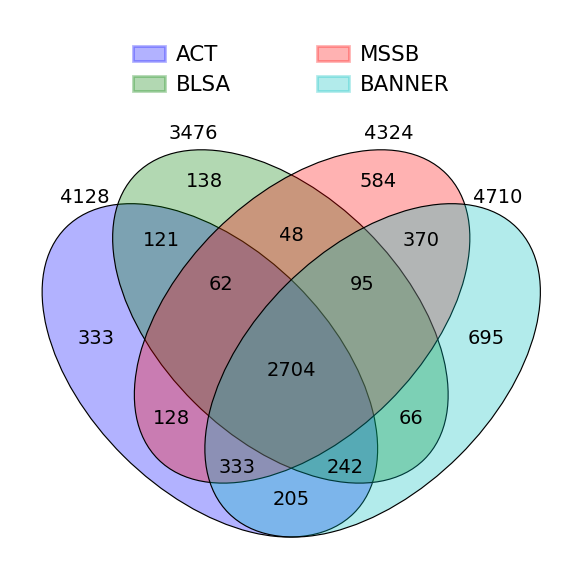

In [28]:
# Now estimate the number of quantified proteins in Synapse data sets and select only those proteins
# which are quantified in all 4 data sets 

banned_columns = set(
['group', 'condition', 'sample', 'replicate', 'BatchMS', 'vs', 'sample+condition'])

prot_cnt = Counter()
prot_all_batches = set()
prot_by_dataset = defaultdict(set)

n_BatchOrig = len(set(df1['BatchOrig']))
for BatchOrig in set(df1['BatchOrig']):   
    i_cnt = 0
    oname = 'DQ2_2024_%s_proteins_LFQ.tsv' % (BatchOrig, )
    dft = pd.read_table(os.path.join(infolder, oname))
    for cc in dft.columns:
        if cc not in banned_columns:
            if cc != 'File Name':
                prot_by_dataset[BatchOrig].add(cc)
            prot_cnt[cc] += 1
            i_cnt += 1
    print(BatchOrig, i_cnt)
            
for k, v in prot_cnt.items():
    if v >= 4:
        prot_all_batches.add(k)
print('Total number of proteins: %d' % (len(prot_cnt) - 1, ))
print('Proteins in all datasets: %d' % (len(prot_all_batches) - 1, ))

sets = {
    'ACT': prot_by_dataset['ACT'],
    'BLSA': prot_by_dataset['BLSA'],
    'MSSB': prot_by_dataset['MSSB'],
    'BANNER': prot_by_dataset['BANNER']}
    
venny4py.venny4py(sets=sets)

In [39]:
# Update loaded sample tables with protein LFQ information

dft_common = False
for BatchOrig in set(df1['BatchOrig']):
    i_cnt = 0
    oname = 'DQ2_2024_%s_proteins_LFQ.tsv' % (BatchOrig, )
    dft = pd.read_table(os.path.join(infolder, oname))
    print(BatchOrig)
    dft = dft[[cc for cc in dft.columns if cc in prot_all_batches]]
    if dft_common is False:
        dft_common = dft.copy()
    else:
        dft_common = pd.concat([dft_common, dft], ignore_index=True)
df1 = pd.merge(df1, dft_common, on='File Name', how='left')
    
        
    
oname = 'DQ2_2024_%s_proteins_LFQ.tsv' % ('DIA', )

dft = pd.read_table(os.path.join(infolder, oname))

cnt_missing_dia = 0
dia_set = set(dft.columns)
for cc in prot_all_batches:
    if cc != 'File Name':
        if cc not in dia_set:
            cnt_missing_dia += 1
print('The number of proteins missing in DIA data: %d' % (cnt_missing_dia, ))

dft_common = False

for BatchOrig in set(df5['BatchOrig']):
    
    
    oname = 'DQ2_2024_%s_proteins_LFQ.tsv' % (BatchOrig, )

    dft = pd.read_table(os.path.join(infolder, oname))
    
    for cc in dft.columns:
        if cc not in banned_columns:
            i_cnt += 1
    print(BatchOrig, i_cnt)

    dft = dft[[cc for cc in dft.columns if cc in prot_all_batches]]
    
    if dft_common is False:
        dft_common = dft.copy()
    else:
        dft_common = pd.concat([dft_common, dft], ignore_index=True)

df5 = pd.merge(df5, dft_common, on='File Name', how='left')
    
for protname in prot_all_batches:
    if protname not in df5.columns:
        df5[protname] = 0

ACT
MSSB
BANNER
BLSA
The number of proteins missing in DIA data: 64
DIA 5492


In [66]:
# Auxilary functions to train ML models

TARGET_NAME = "local_target"
PREDICTION_NAME = "prediction"

def get_X_array(df, feature_columns):
    return df.loc[:, feature_columns].fillna(0).values

def get_features(dataframe, allowed_features=False):
    feature_columns = dataframe.columns
    columns_to_remove = []
    for feature in feature_columns:
        if feature != 'Sex' and not feature.startswith('sp|'):
            columns_to_remove.append(feature)
        if allowed_features is not False and feature not in allowed_features:
            columns_to_remove.append(feature)
    feature_columns = feature_columns.drop(columns_to_remove)
    return list(feature_columns)


def get_Y_array(df):
    return df.loc[:, 'local_target'].values

def get_cat_model_final(df, hyperparameters, feature_columns):
    clf = ExtraTreesRegressor(n_estimators=hyperparameters['n_estimators'],
                                     max_depth=hyperparameters['max_depth'], random_state=0,
                                     min_samples_leaf=hyperparameters['min_samples_leaf'],
                                    min_groups_leaf = hyperparameters['min_groups_leaf'],
                                    min_weight_groups = hyperparameters['min_weight_groups'],
                                    min_samples_split = hyperparameters['min_samples_split'],
                                    n_jobs = hyperparameters['n_jobs'], max_features = hyperparameters['max_features']
                                    )    
    train = df
    X_train = get_X_array(train, feature_columns)
    y_train = get_Y_array(train)
    groups_train = train['G'].values
    sw_train = train['W'].values
    clf.fit(X_train, y_train, sample_weight=sw_train, groups=groups_train.astype(np.int32))
    return clf

def calc_arrays_kfold(mdi_res2):
    
    all_names = []
    all_a = []
    all_l = []
    all_bb0 = []
    ii_range = np.array([0, 1, 2])

    useful_features = set()
    for k in mdi_res2.keys():
        vbase = [np.mean(mdi_res2[k][ii]) for ii in ii_range+1]
        a, b, R2, std_val = aux.linear_regression(ii_range, vbase)
        diff_ar = np.diff(vbase)
        diff_ar = np.clip(diff_ar, a_min=None, a_max=0)
        max_dropdown = np.abs(diff_ar).max()/max(1e-10, b)
        all_l.append(vbase[-1])
        all_bb0.append(max_dropdown)
        all_names.append(k)
        all_a.append(a * 1000)

    all_a = np.array(all_a)
    all_names = np.array(all_names)
    all_l = np.log10(all_l)
    all_bb0 = np.array(all_bb0)
    idx_sort = np.argsort(-all_l)
    all_names = all_names[idx_sort]
    all_a = all_a[idx_sort]
    all_l = all_l[idx_sort]
    all_bb0 = all_bb0[idx_sort]

    return all_names, all_a, all_l, all_bb0

def calibrate_RT_gaus(bwidth, mass_left, mass_right, true_md):

    bbins = np.arange(-mass_left, mass_right, bwidth)
    H1, b1 = np.histogram(true_md, bins=bbins)
    b1 = b1 + bwidth
    b1 = b1[:-1]


    popt, pcov = curve_fit(noisygaus, b1, H1, p0=[1, np.median(true_md), bwidth * 5, 1])
    mass_shift, mass_sigma = popt[1], abs(popt[2])
    return mass_shift, mass_sigma, pcov[0][0]

def calibrate_RT_gaus_full(rt_diff_tmp):
    RT_left = -min(rt_diff_tmp)
    RT_right = max(rt_diff_tmp)

    try:
        start_width = (scoreatpercentile(rt_diff_tmp, 95) - scoreatpercentile(rt_diff_tmp, 5)) / 100
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(start_width, RT_left, RT_right, rt_diff_tmp)
    except:
        start_width = (scoreatpercentile(rt_diff_tmp, 95) - scoreatpercentile(rt_diff_tmp, 5)) / 50
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(start_width, RT_left, RT_right, rt_diff_tmp)
    if np.isinf(covvalue):
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(0.1, RT_left, RT_right, rt_diff_tmp)
    if np.isinf(covvalue):
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus(1.0, RT_left, RT_right, rt_diff_tmp)
    return XRT_shift, XRT_sigma, covvalue

def noisygaus(x, a, x0, sigma, b):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + b


bestparams_base = {'max_depth': 6,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_groups_leaf': 1,
 'min_weight_groups': 0,
 'n_estimators': 1000,
 'max_features': None,
 'n_jobs': 10}

In [ ]:
# Train models using k-fold CV described in the manuscript

num_cv_folds = len(set(df1['G']))

res_list = dict()
a_dict = dict()


all_cond = ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control', 'RankedBraak', 'RankedCerad']
for cond in all_cond:
    
    if cond == 'AD_vs_AsymAD':
        dfn = df1[df1['Group'] != 'Control'].copy()
        ltn_map = {
            'AD': 1,
            'AsymAD': 0,
        }
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
        
    elif cond == 'AD_vs_Control':
        dfn = df1[df1['Group'] != 'AsymAD'].copy()
        ltn_map = {
            'AD': 1,
            'Control': 0,
        }
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
        
    elif cond == 'AsymAD_vs_Control':
        dfn = df1[df1['Group'] != 'AD'].copy()
        ltn_map = {
            'AsymAD': 1,
            'Control': 0,
        }
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
    
    elif cond == 'RankedBraak':
        dfn = df1.copy()
        ltn_map = {
            'AD': 1,
            'AsymAD': -1,
            'Control': 0,
        }
        
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x]) * (dfn['Braak'])
        dfn['local_target'] = dfn['local_target'].apply(lambda x: int(x) + 6 if x < 0 else (int(x) + 2 if x > 0 else 4) )
    
    
    elif cond == 'RankedCerad':
        dfn = df1.copy()
        ltn_map = {
            'AD': 1,
            'AsymAD': -1,
            'Control': 0,
        }
    
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x]) * (dfn['CERAD'])
        dfn['local_target'] = dfn['local_target'].apply(lambda x: int(x) + 3 if x < 0 else (int(x) + 2 if x > 0 else 3) )
    
    else:
        print('unknown condition')
        break
        
    dfn['G'] = dfn['Batch']+1
    gcount = Counter(dfn['G'])
    dfn['W'] = 1

    base_scores = defaultdict(list)
    a_dict[cond] = defaultdict(list)
    filename_to_fold_map = {}
    SEED = 42
    
    for kfold_g in range(1, num_cv_folds+1, 1):
        train_df_c = dfn[dfn['G'].apply(lambda x: x != kfold_g)].copy()
        test_df_c = dfn[dfn['G'].apply(lambda x: x == kfold_g)].copy()

        train_df_c['W'] = 1.0

        mdi_res2 = defaultdict(list)
        mdi_res2 = dict()
        min_w_values2 = []

        feature_columns = get_features(dfn)
        for fn in feature_columns:
            mdi_res2[fn] = defaultdict(list)
    

        for ii in [3, 2, 1, ]:
            bestparams = copy(bestparams_base)
            bestparams['min_groups_leaf'] = ii

            rfr = get_cat_model_final(train_df_c, bestparams, feature_columns)
            
            xarr = get_X_array(test_df_c, feature_columns)
            yarr = get_Y_array(test_df_c)
            base_preds = rfr.predict(xarr)
            
            if 'Ranked' in cond:
                base_score = np.corrcoef(rankdata(yarr, method='min'), rankdata(base_preds, method='min'))[0][1]
            else:
                base_score = roc_auc_score(yarr, base_preds)
            base_scores[ii].append(base_score)

            cnt_check = 0
            min_w_values2.append(ii)
            fn_fi_array = sorted(list(zip(range(len(feature_columns)), feature_columns, rfr.feature_importances_)), key=lambda x: -x[2])
            for ftr_idx, fn, fv in fn_fi_array:
                cnt_check += 1
                mdi_res2[fn][ii].append(fv)
                        
        all_names, all_a, all_l, all_bb0 = calc_arrays_kfold(mdi_res2)
        idx_sort = np.argsort(-all_l)
        for k, a in zip(all_names[idx_sort], all_a[idx_sort]):              
            a_dict[cond][k].append(a)
                
    res_list[cond] = (mdi_res2, '', base_scores)
    print(cond + ' was finished' + '\n')

In [64]:
# Print AUC values for (K-fold, All features)

for cond in res_list.keys():
    if not cond.startswith('Ranked'):
        base_scores = res_list[cond][2]
        print('\n' + cond)
        for mgl in [1, 2, 3]:
            mn_auc = np.mean(base_scores[mgl])
            std_auc = np.std(base_scores[mgl])
            if mgl == 1:
                pval_auc = 1.0
            else:
                pval_auc = wilcoxon(base_scores[mgl], base_scores[1])[1]
            print('min_groups_leaf', mgl, '%.3f / %.3f / %.3f' % (mn_auc, std_auc, pval_auc))


AD_vs_AsymAD
min_groups_leaf 1 0.657 / 0.092 / 1.000
min_groups_leaf 2 0.671 / 0.098 / 0.125
min_groups_leaf 3 0.705 / 0.115 / 0.125

AD_vs_Control
min_groups_leaf 1 0.914 / 0.069 / 1.000
min_groups_leaf 2 0.924 / 0.061 / 0.285
min_groups_leaf 3 0.923 / 0.064 / 0.109

AsymAD_vs_Control
min_groups_leaf 1 0.760 / 0.069 / 1.000
min_groups_leaf 2 0.783 / 0.059 / 0.375
min_groups_leaf 3 0.791 / 0.048 / 0.125


In [71]:
# Print Proteins significant for the generalizability of the models as described in the manuscript
# Report the probabilities defined by Eq. 2 in the manuscript

feature_columns3_multicond = defaultdict(set)
for cond in a_dict.keys():
    print(cond)
        
    ar1 = defaultdict(list)    
    ar2 = dict()
    ar2_shift = dict()
    ar3 = defaultdict(list)
    ar_names = []
    for kk, vv in a_dict[cond].items():
        for iii in range(len(vv)):
            ar1[iii].append(vv[iii])
        ar_names.append(kk)

    for iii in ar1.keys():
        XRT_shift, XRT_sigma, covvalue = calibrate_RT_gaus_full(ar1[iii])
        ar2[iii] = XRT_sigma
        ar2_shift[iii] = XRT_shift
    
    for iii in ar2.keys():
        for v in ar1[iii]:
            ar3[iii].append(scipy.stats.norm.sf((v-ar2_shift[iii])/ar2[iii]))
            
    p_values = []
    for idx in range(len(ar_names)):
        p_values.append(1 - np.prod([1 - ar3[iii][idx] for iii in ar3.keys()]))
        
    ar_names = np.array(ar_names)
    for k, pval in sorted(list(zip(ar_names, p_values)), key=lambda x: x[1]):
        if pval <= 0.05:
            print(k, '\t', pval)
            feature_columns3_multicond[cond].add(k)

    print('\n\n')
    
for cond in feature_columns3_multicond.keys():
    feature_columns3_multicond[cond] = list(feature_columns3_multicond[cond])

AD_vs_AsymAD
sp|P04792|HSPB1_HUMAN 	 0.0
sp|Q9Y2J0|RP3A_HUMAN 	 0.0
sp|Q8NFI4|F10A5_HUMAN 	 1.5654144647214707e-14
sp|O14773|TPP1_HUMAN 	 0.00022189631457836256
sp|Q96EQ0|SGTB_HUMAN 	 0.0010054262083826204
sp|O00330|ODPX_HUMAN 	 0.0024686871376304875
sp|O43236|SEPT4_HUMAN 	 0.007772768027462851
sp|Q9UPZ9|ICK_HUMAN 	 0.01532595731905062
sp|P07919|QCR6_HUMAN 	 0.01715222684322404
sp|P19012|K1C15_HUMAN 	 0.042684693018531394
sp|Q9Y6M9|NDUB9_HUMAN 	 0.04311135840618441
sp|Q99719|SEPT5_HUMAN 	 0.049578399985354404



AD_vs_Control
sp|P63096|GNAI1_HUMAN 	 0.0
sp|P05067|A4_HUMAN 	 0.0
sp|P31146|COR1A_HUMAN 	 0.0
sp|Q16181|SEPT7_HUMAN 	 0.0
sp|P08754|GNAI3_HUMAN 	 0.0
sp|Q9NQC3|RTN4_HUMAN 	 0.0
sp|P04899|GNAI2_HUMAN 	 0.0
sp|P48735|IDHP_HUMAN 	 4.546363285840016e-13
sp|P60763|RAC3_HUMAN 	 7.386313782831166e-13
sp|Q9H9B4|SFXN1_HUMAN 	 2.632116746781321e-12
sp|Q9Y2J0|RP3A_HUMAN 	 3.2418631112918206e-09
sp|P36873|PP1G_HUMAN 	 6.046756528821362e-08
sp|P10909|CLUS_HUMAN 	 1.2837931118170332e-07
sp|

In [74]:
# Extract proteins which are important to explain AsymAD group (As described in the manuscipt)

print('%s\t%s\t%s\t%s\t%s\t%s' % ('Model', 'dbname', 'p-value vs AD', 'p-value vs Ctrl', 'Median FC in AsymAD', 'Median FC in AD'))
tmp = df1.copy()
total_ML_proteins = set()
for cond in feature_columns3_multicond.keys():
    for prot in feature_columns3_multicond[cond]:
        total_ML_proteins.add(prot)
        ar_asym = tmp[tmp['Group'] == 'AsymAD'][prot].values
        ar_ad = tmp[tmp['Group'] == 'AD'][prot].values
        ar_control = tmp[tmp['Group'] == 'Control'][prot].values
        p_vs_ad = ttest_ind(ar_asym, ar_ad)[1]
        p_vs_ctl = ttest_ind(ar_asym, ar_control)[1]
        p_ad_vs_ctl = ttest_ind(ar_ad, ar_control)[1]
        fc_asym = np.median(ar_asym)
        fc_ad = np.median(ar_ad)
        fc_control = np.median(ar_control)
        if abs(fc_asym) >= 0.05 and (abs(fc_asym/fc_ad) >= 5 or np.sign(fc_asym) != np.sign(fc_ad)):
            print('%s\t%s\t%.4f\t%.4f\t%.2f\t%.2f' % (cond, prot, p_vs_ad, p_vs_ctl, fc_asym, fc_ad))
            
print('\n\n', len(total_ML_proteins))

Model	dbname	p-value vs AD	p-value vs Ctrl	Median FC in AsymAD	Median FC in AD
AsymAD_vs_Control	sp|Q96KP4|CNDP2_HUMAN	0.0007	0.0010	0.10	0.02
AsymAD_vs_Control	sp|P27695|APEX1_HUMAN	0.0211	0.0378	0.12	-0.01
RankedBraak	sp|P02787|TRFE_HUMAN	0.0004	0.4876	0.07	-0.10


 76


<Figure size 1280x960 with 0 Axes>

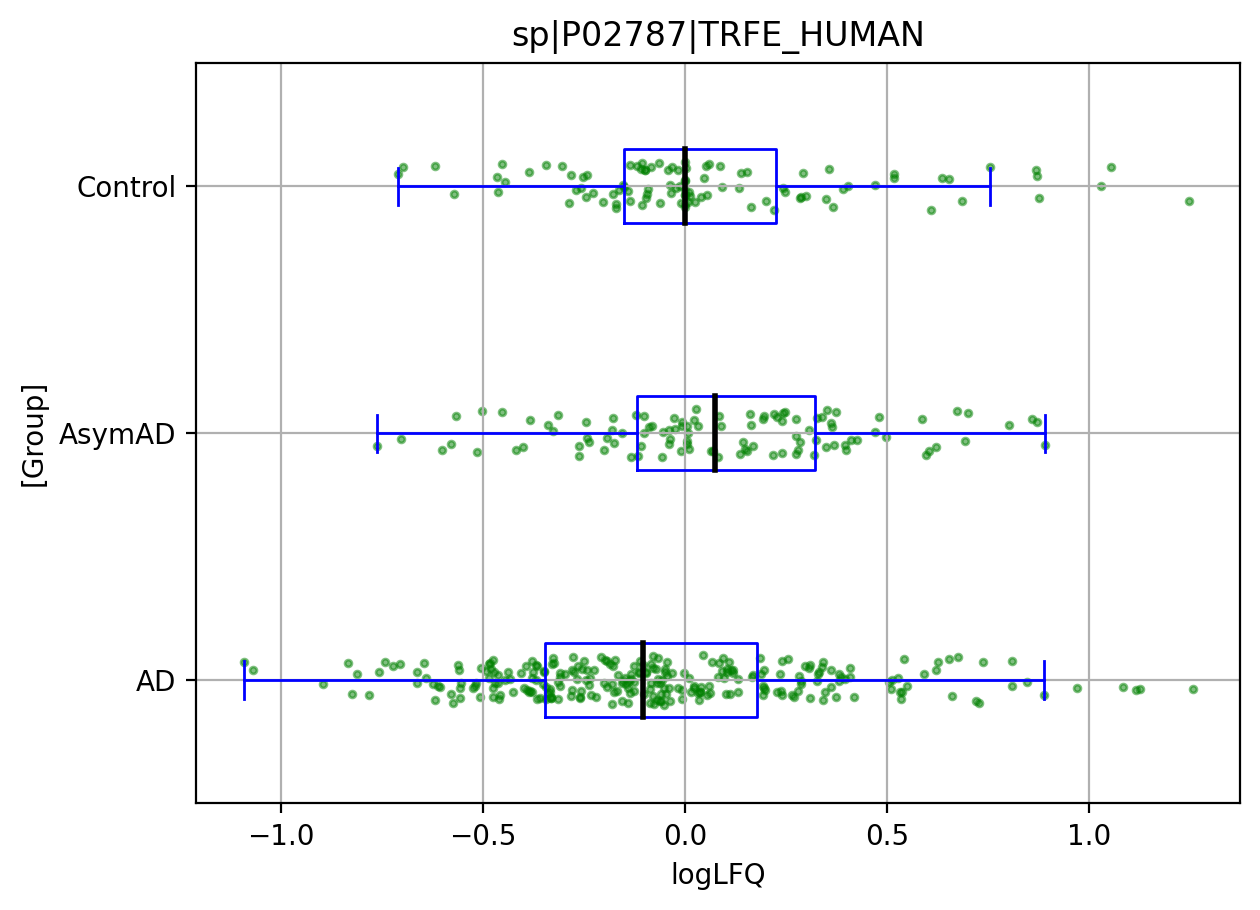

<Figure size 1280x960 with 0 Axes>

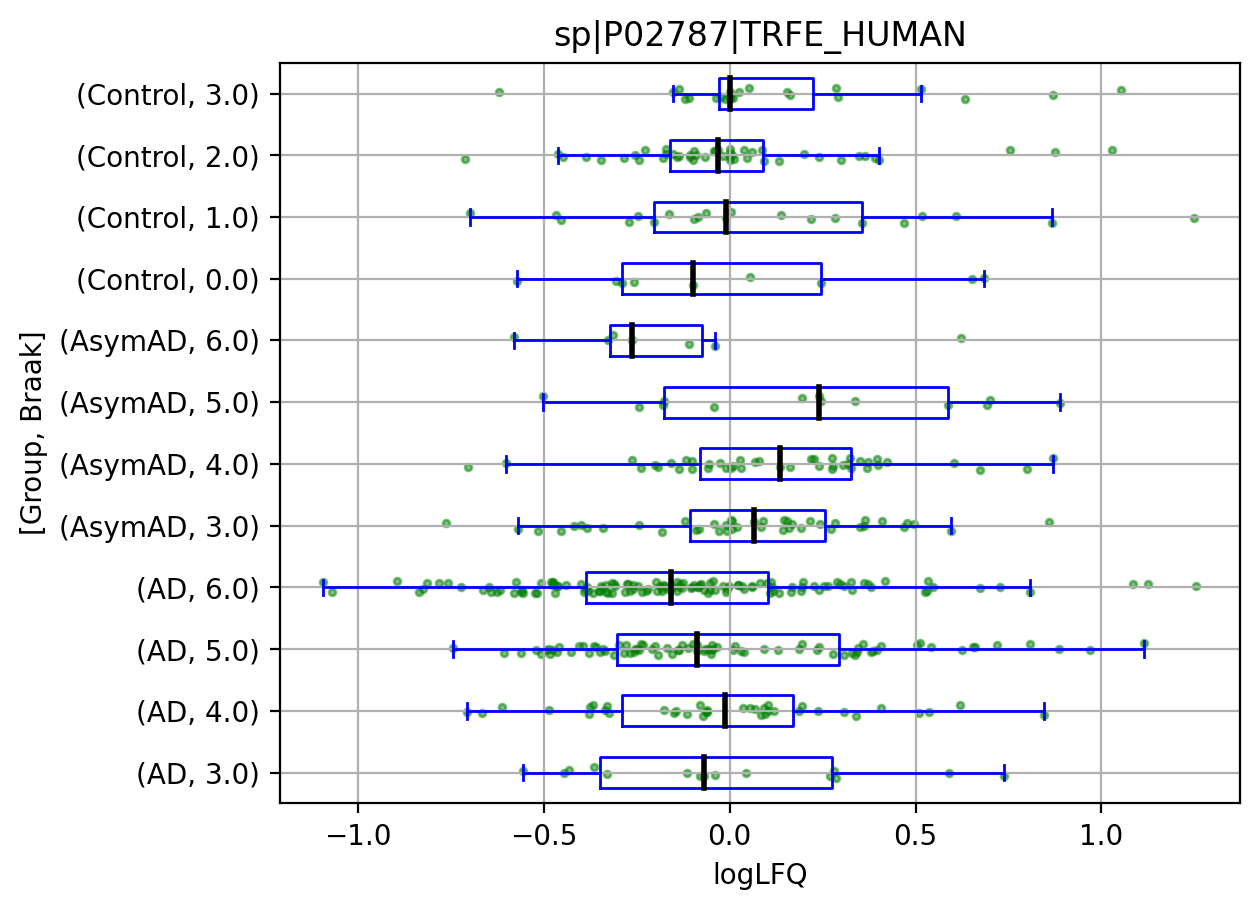

In [92]:
# Plot figure for one of the interesting proteins

groupings = [
    ['Group', ],
    ['Group', 'Braak'],
]

prot_name = 'sp|P02787|TRFE_HUMAN'
tmp = df1.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()



In [ ]:
# Train models using k-fold CV and all folds together.
# Here only proteins significant for the generalizability were used!

num_cv_folds = len(set(df1['G']))

res_list333 = dict()
all_cond = ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control', 'RankedBraak', 'RankedCerad']

all_models_final = dict()
all_models_allftrs = dict()


all_models_final_nokfold = dict()
all_models_allftrs_nokfold = dict()

for cond in all_cond:
    
    all_models_final[cond] = defaultdict(list)
    all_models_allftrs[cond] = defaultdict(list)
    all_models_final_nokfold[cond] = defaultdict(list)
    all_models_allftrs_nokfold[cond] = defaultdict(list)
    
    if cond == 'AD_vs_AsymAD':
        dfn = df1[df1['Group'] != 'Control'].copy()
        ltn_map = {
            'AD': 1,
            'AsymAD': 0,
        }
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])

    elif cond == 'AD_vs_Control':
        dfn = df1[df1['Group'] != 'AsymAD'].copy()
        ltn_map = {
            'AD': 1,
            'Control': 0,
        }
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
        
    elif cond == 'AsymAD_vs_Control':
        dfn = df1[df1['Group'] != 'AD'].copy()
        ltn_map = {
            'AsymAD': 1,
            'Control': 0,
        }
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x])
    
    elif cond == 'RankedBraak':
        dfn = df1.copy()
        ltn_map = {
            'AD': 1,
            'AsymAD': -1,
            'Control': 0,
        }
        
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x]) * (dfn['Braak'])
        dfn['local_target'] = dfn['local_target'].apply(lambda x: int(x) + 6 if x < 0 else (int(x) + 2 if x > 0 else 4) )
    
    
    elif cond == 'RankedCerad':
        dfn = df1.copy()
        ltn_map = {
            'AD': 1,
            'AsymAD': -1,
            'Control': 0,
        }
    
        dfn['local_target'] = dfn['Group'].apply(lambda x: ltn_map[x]) * (dfn['CERAD'])
        dfn['local_target'] = dfn['local_target'].apply(lambda x: int(x) + 3 if x < 0 else (int(x) + 2 if x > 0 else 3) )
    
    
    else:
        print('unknown condition')
        break
        
        
    dfn['G'] = dfn['Batch']+1
    gcount = Counter(dfn['G'])
    dfn['W'] = 1
    
    base_scores = defaultdict(list)
    
    
    filename_to_fold_map = {}
    SEED = 42
    
    train_df_c = dfn.copy()
    for ii in [4, 3, 2, 1, ]:
        bestparams = copy(bestparams_base)
        bestparams['min_groups_leaf'] = ii
        rfr = get_cat_model_final(train_df_c, bestparams, feature_columns3_multicond[cond])
        all_models_final_nokfold[cond][ii].append(rfr)

        bestparams = copy(bestparams_base)
        bestparams['min_groups_leaf'] = ii
        rfr2 = get_cat_model_final(train_df_c, bestparams, feature_columns)
        all_models_allftrs_nokfold[cond][ii].append(rfr2)

    for kfold_g in range(1, num_cv_folds+1, 1):
        train_df_c = dfn[dfn['G'].apply(lambda x: x != kfold_g)].copy()
        test_df_c = dfn[dfn['G'].apply(lambda x: x == kfold_g)].copy()

        train_df_c['W'] = 1.0

        features_to_skip = set()

        for ii in [3, 2, 1, ]:
            bestparams = copy(bestparams_base)
            bestparams['min_groups_leaf'] = ii

            rfr = get_cat_model_final(train_df_c, bestparams, feature_columns3_multicond[cond])
            all_models_final[cond][ii].append(rfr)
            
            bestparams = copy(bestparams_base)
            bestparams['min_groups_leaf'] = ii
            
            rfr2 = get_cat_model_final(train_df_c, bestparams, feature_columns)
            all_models_allftrs[cond][ii].append(rfr2)
            
            xarr = get_X_array(test_df_c, feature_columns3_multicond[cond])
            yarr = get_Y_array(test_df_c)
            base_preds = rfr.predict(xarr)

            if 'Ranked' in cond:
                base_score = np.corrcoef(rankdata(yarr, method='min'), rankdata(base_preds, method='min'))[0][1]
            else:
                base_score = roc_auc_score(yarr, base_preds)

            base_scores[ii+100].append(base_score)
#             print('!', base_score, kfold_g, ii+100)
                
    res_list333[cond] = ('', '', base_scores)
    print(cond + ' was finished' + '\n')

AD_vs_AsymAD was finished

AD_vs_Control was finished

AsymAD_vs_Control was finished



In [83]:
# Predict and estimate results using DIA holdout data set

print('Using TOP features, NO K FOLD\n')

res_list_dia_top = defaultdict(list)

for cond in all_models_final_nokfold.keys():
    if '_vs_' in cond:
        for ii in all_models_final_nokfold[cond].keys():
            df5['preds_%s_%d' % (cond, ii)] = 0
            for rfr in all_models_final_nokfold[cond][ii]:
                xarr = get_X_array(df5, feature_columns3_multicond[cond])
                preds = rfr.predict(xarr)
                df5['preds_%s_%d' % (cond, ii)] += preds
            df5['preds_%s_%d' % (cond, ii)] /= len(all_models_final_nokfold[cond][ii])
        

for cond in all_models_final_nokfold.keys():
    if '_vs_' in cond:
        base_scores = defaultdict(list)
        for ii in all_models_final_nokfold[cond].keys():
            tmp = df5.copy()
            if cond == 'AD_vs_Control':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 1 if 'AD' in x else 0)
                tmp = tmp[tmp['Condition'] != 'Control High Path']
            elif cond == 'AD_vs_AsymAD':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 1 if 'AD' in x else 0)
                tmp = tmp[tmp['Condition'] != 'Control Low Path']
            elif cond == 'AsymAD_vs_Control':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 1 if 'High Path' in x else 0)
                tmp = tmp[tmp['Condition'].apply(lambda x: 'AD' not in x)]
            elif cond == 'RankedBraak':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 0 if 'High Path' in x else 1)
            elif cond == 'RankedCerad':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 0 if 'High Path' in x else 1)
            else:
                print('W?????')
                break

            base_preds = tmp['preds_%s_%d' % (cond, ii)]
            yarr = tmp['local_target_AD']
            base_score = roc_auc_score(yarr, base_preds)
#             print(cond, ii, base_score)
            base_scores[ii+100].append(base_score)
            
        res_list_dia_top[cond] = ('', '', base_scores)
        
        
        
print('Using ALL features, NO K FOLD\n')

res_list_dia_all = defaultdict(list)

for cond in all_models_allftrs_nokfold.keys():
    if '_vs_' in cond:
        for ii in all_models_allftrs_nokfold[cond].keys():
            df5['preds_%s_%d' % (cond, ii)] = 0
            for rfr in all_models_allftrs_nokfold[cond][ii]:
                xarr = get_X_array(df5, get_features(df1))
                preds = rfr.predict(xarr)
                df5['preds_%s_%d' % (cond, ii)] += preds
            df5['preds_%s_%d' % (cond, ii)] /= len(all_models_allftrs_nokfold[cond][ii])
        

for cond in all_models_allftrs_nokfold.keys():
    if '_vs_' in cond:
        base_scores = defaultdict(list)
        for ii in all_models_allftrs_nokfold[cond].keys():
            tmp = df5.copy()
            if cond == 'AD_vs_Control':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 1 if 'AD' in x else 0)
                tmp = tmp[tmp['Condition'] != 'Control High Path']
            elif cond == 'AD_vs_AsymAD':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 1 if 'AD' in x else 0)
                tmp = tmp[tmp['Condition'] != 'Control Low Path']
            elif cond == 'AsymAD_vs_Control':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 1 if 'High Path' in x else 0)
                tmp = tmp[tmp['Condition'].apply(lambda x: 'AD' not in x)]
            elif cond == 'RankedBraak':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 0 if 'High Path' in x else 1)
            elif cond == 'RankedCerad':
                tmp['local_target_AD'] = tmp['Condition'].apply(lambda x: 0 if 'High Path' in x else 1)
            else:
                print('W?????')
                break

            base_preds = tmp['preds_%s_%d' % (cond, ii)]
            yarr = tmp['local_target_AD']
            base_score = roc_auc_score(yarr, base_preds)
#             print(cond, ii, base_score)
            base_scores[ii].append(base_score)
            
        res_list_dia_all[cond] = ('', '', base_scores)


Using TOP features, NO K FOLD

Using ALL features, NO K FOLD



In [88]:
# Print AUC values:
# for both K-fold and holdout data
# for both all quantified and selected proteins

list_of_groups = ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control']


# K-fold All features
print('K-fold, All proteins. average AUC/std AUC/p-value')
print('\t'.join(['min_groups_leaf', ] + list_of_groups))
for mgl in [1, 2, 3]:
    to_print = [str(mgl), ]
    for cond in ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control']:
        base_scores = res_list[cond][2]
        mn_auc = np.mean(base_scores[mgl])
        std_auc = np.std(base_scores[mgl])
        if mgl == 1:
            pval_auc = 1.0
        else:
            pval_auc = wilcoxon(base_scores[mgl], base_scores[1])[1]
        to_print.append('%.3f / %.3f / %.3f' % (mn_auc, std_auc, pval_auc))
    print('\t'.join(to_print))
    
print('\n')

# Holdout All features
print('Holdout, All proteins. average AUC')
print('\t'.join(['min_groups_leaf', ] + list_of_groups))
for mgl in [1, 2, 3, 4]:
    to_print = [str(mgl), ]
    for cond in ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control']:
        base_scores = res_list_dia_all[cond][2]
        mn_auc = np.mean(base_scores[mgl])
        std_auc = np.std(base_scores[mgl])
        to_print.append('%.3f' % (mn_auc, ))
    print('\t'.join(to_print))    
    
    
print('\n')
    
# K-fold Selected features
print('K-fold, Selected proteins. average AUC/std AUC/p-value')
print('\t'.join(['min_groups_leaf', ] + list_of_groups))
for mgl in [101, 102, 103]:
    to_print = [str(mgl-100), ]
    for cond in ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control']:
        base_scores = res_list333[cond][2]
#         print('\n' + cond)
        mn_auc = np.mean(base_scores[mgl])
        std_auc = np.std(base_scores[mgl])
        if mgl == 101:
            pval_auc = 1.0
        else:
            pval_auc = wilcoxon(base_scores[mgl], base_scores[101])[1]
#         print('min_groups_leaf', mgl, '%.3f / %.3f / %.3f' % (mn_auc, std_auc, pval_auc))
        to_print.append('%.3f / %.3f / %.3f' % (mn_auc, std_auc, pval_auc))
    print('\t'.join(to_print))
    
print('\n')
    
# Holdout Selected features
print('Holdout, Selected proteins. average AUC')
print('\t'.join(['min_groups_leaf', ] + list_of_groups))
for mgl in [101, 102, 103, 104]:
    to_print = [str(mgl-100), ]
    for cond in ['AD_vs_AsymAD', 'AD_vs_Control', 'AsymAD_vs_Control']:
        base_scores = res_list_dia_top[cond][2]
        mn_auc = np.mean(base_scores[mgl])
        std_auc = np.std(base_scores[mgl])
        to_print.append('%.3f' % (mn_auc, ))
    print('\t'.join(to_print))    
    
    
print('\n')

K-fold, All proteins. average AUC/std AUC/p-value
min_groups_leaf	AD_vs_AsymAD	AD_vs_Control	AsymAD_vs_Control
1	0.657 / 0.092 / 1.000	0.914 / 0.069 / 1.000	0.760 / 0.069 / 1.000
2	0.671 / 0.098 / 0.125	0.924 / 0.061 / 0.285	0.783 / 0.059 / 0.375
3	0.705 / 0.115 / 0.125	0.923 / 0.064 / 0.109	0.791 / 0.048 / 0.125


Holdout, All proteins. average AUC
min_groups_leaf	AD_vs_AsymAD	AD_vs_Control	AsymAD_vs_Control
1	0.861	0.976	0.788
2	0.881	0.979	0.788
3	0.885	0.979	0.818
4	0.883	0.968	0.808


K-fold, Selected proteins. average AUC/std AUC/p-value
min_groups_leaf	AD_vs_AsymAD	AD_vs_Control	AsymAD_vs_Control
1	0.761 / 0.104 / 1.000	0.956 / 0.041 / 1.000	0.861 / 0.071 / 1.000
2	0.763 / 0.097 / 0.875	0.953 / 0.041 / 0.109	0.865 / 0.076 / 0.285
3	0.761 / 0.107 / 0.875	0.949 / 0.042 / 0.125	0.866 / 0.081 / 0.625


Holdout, Selected proteins. average AUC
min_groups_leaf	AD_vs_AsymAD	AD_vs_Control	AsymAD_vs_Control
1	0.861	0.974	0.808
2	0.859	0.974	0.808
3	0.866	0.968	0.818
4	0.872	0.968	0.818




<Figure size 1280x960 with 0 Axes>

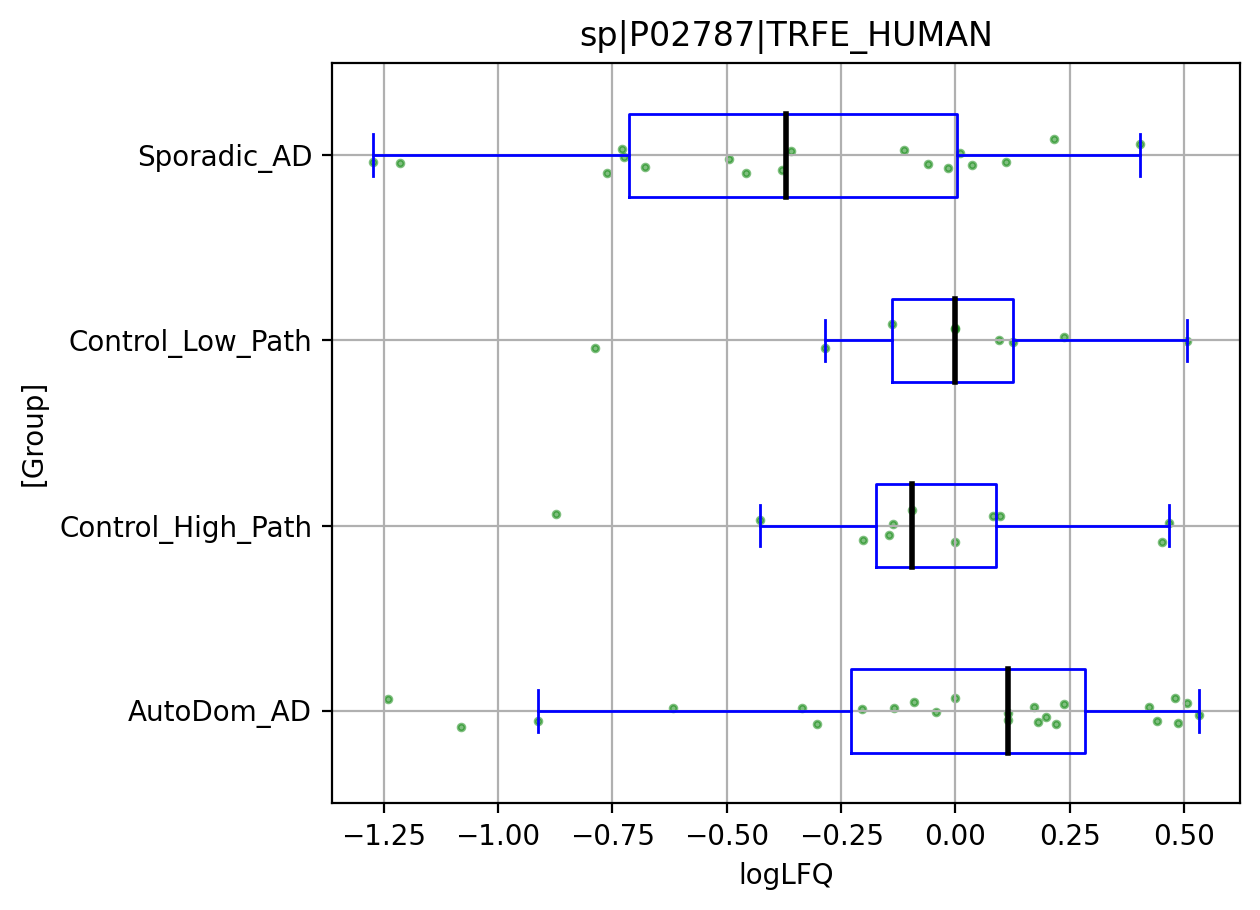

In [93]:
# Plot figure for one of the interesting proteins in DIA data

groupings = [
    ['Group', ],
]

prot_name = 'sp|P02787|TRFE_HUMAN'
tmp = df5.copy()

for gr in groupings:
    fig = plt.figure()
    tmp.boxplot(column=prot_name,by=gr, vert=False,boxprops = dict(linestyle='-', linewidth=1, color='b'),
            flierprops=dict(linestyle='-', linewidth=1, color='b'),
             medianprops=dict(linestyle='-', linewidth=2, color='k'),
             whiskerprops=dict(linestyle='-', linewidth=1, color='b'),
             capprops=dict(linestyle='-', linewidth=1, color='b'), showfliers=False)
    grdf = tmp.groupby(by=gr)
    for idx, tmp2 in enumerate(grdf):
        rar = np.array([random.random() for _ in range(len(tmp2[1]))])
        plt.scatter(tmp2[1][prot_name], idx+1+rar/5-0.1, s=6, c='g', alpha=0.5)
    plt.suptitle('')
    plt.xlabel('logLFQ')
    plt.tight_layout()

